In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import pandas as pd
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from wfdb import processing
import numpy as np

In [3]:
data = pd.read_csv("X_train.csv")
answers = pd.read_csv("y_train.csv")

In [4]:
data = (pd.merge(data ,answers, on = "Unnamed: 0"))
data['age'] = (data['age'] - data['age'].mean(axis = 0))/data['age'].std(axis = 0)
data = data.drop( ["Unnamed: 0"], axis = 1)

In [5]:
signal_df = pd.read_csv("signal_data.csv", sep="#", index_col=False)
for column in signal_df.columns:
    signal_df[column] = signal_df[column].apply(lambda row: np.fromstring(row[1:-1], sep="  ", dtype=np.uint64))

In [6]:
valid_size = 0.1
random_seed = 7
num_train = len(data)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))


np.random.seed(random_seed)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]

In [7]:
from basics import bandpass

In [8]:
def apply_bandpass(row, low_cut, high_cut):
    return [bandpass(row[i : i + 5000], 500, low_cut, high_cut) for i in range(2, 55003, 5000)]
        
def filter_signal(data, low_cut, high_cut):
    return np.apply_along_axis(lambda x: apply_bandpass(x, low_cut, high_cut),1, data)

In [9]:
def moving_average(data_set, periods=3):
    weights = np.ones(periods) / periods
    return np.convolve(data_set, weights, mode='valid')

In [10]:
from scipy.stats import skew, kurtosis

In [11]:
def get_features(ecg, peaks, name):
    ecg_moving_50 = moving_average(ecg, 50)
    ecg_moving_100 = moving_average(ecg, 100)
    ecg_moving_300 = moving_average(ecg, 300)
    features = {
        name+"_overall_mean":np.mean(ecg),
        name+"_overall_median":np.median(ecg),
        name+"_overall_std":np.std(ecg),
        name+"_overall_quantile_0.01":np.quantile(ecg, 0.01),
        name+"_overall_quantile_0.05":np.quantile(ecg, 0.05),
        name+"_overall_quantile_0.25":np.quantile(ecg, 0.25),
        name+"_overall_quantile_0.75":np.quantile(ecg, 0.75),
        name+"_overall_quantile_0.95":np.quantile(ecg, 0.95),
        name+"_overall_quantile_0.99":np.quantile(ecg, 0.99),
        name+"_overall_skew" : skew(ecg),
        name+"_overall_kurtosis" : kurtosis(ecg),
        
        
        #name+"_peaks_mean":np.mean(ecg[peaks]),
        #name+"_peaks_median":np.median(ecg[peaks]),
        #name+"_peaks_std":np.std(ecg[peaks]),
        #name+"_peaks_quantile_0.01":np.quantile(ecg[peaks], 0.01),
        #name+"_peaks_quantile_0.05":np.quantile(ecg[peaks], 0.05),
        #name+"_peaks_quantile_0.25":np.quantile(ecg[peaks], 0.25),
        #name+"_peaks_quantile_0.75":np.quantile(ecg[peaks], 0.75),
        #name+"_peaks_quantile_0.95":np.quantile(ecg[peaks], 0.95),
        #name+"_peaks_quantile_0.99":np.quantile(ecg[peaks], 0.99),
        
        name+"_moving_50_mean":np.mean(ecg_moving_50),
        name+"_moving_50_median":np.median(ecg_moving_50),
        name+"_moving_50_std":np.std(ecg_moving_50),
        name+"_moving_50_quantile_0.01":np.quantile(ecg_moving_50, 0.01),
        name+"_moving_50_quantile_0.05":np.quantile(ecg_moving_50, 0.05),
        name+"_moving_50_quantile_0.25":np.quantile(ecg_moving_50, 0.25),
        name+"_moving_50_quantile_0.75":np.quantile(ecg_moving_50, 0.75),
        name+"_moving_50_quantile_0.95":np.quantile(ecg_moving_50, 0.95),
        name+"_moving_50_quantile_0.99":np.quantile(ecg_moving_50, 0.99),
        name+"_moving_50_skew" : skew(ecg_moving_50),
        name+"_moving_50_kurtosis" : kurtosis(ecg_moving_50),
        
        name+"_moving_100_mean":np.mean(ecg_moving_100),
        name+"_moving_100_median":np.median(ecg_moving_100),
        name+"_moving_100_std":np.std(ecg_moving_100),
        name+"_moving_100_quantile_0.01":np.quantile(ecg_moving_100, 0.01),
        name+"_moving_100_quantile_0.05":np.quantile(ecg_moving_100, 0.05),
        name+"_moving_100_quantile_0.25":np.quantile(ecg_moving_100, 0.25),
        name+"_moving_100_quantile_0.75":np.quantile(ecg_moving_100, 0.75),
        name+"_moving_100_quantile_0.95":np.quantile(ecg_moving_100, 0.95),
        name+"_moving_100_quantile_0.99":np.quantile(ecg_moving_100, 0.99),
        name+"_moving_100_skew" : skew(ecg_moving_100),
        name+"_moving_100_kurtosis" : kurtosis(ecg_moving_100),
    }
    return features

In [12]:
def get_features_dataset(data, peaks):
    data_values = data.values
    peaks_values = peaks.values
    filtered_data = filter_signal(data_values, 5, 20)
    columns = peaks.columns
    feature_array = []
    for ind in range(len(data)):
        all_features = {"age":data_values[ind][0], "gender":data_values[ind][1]}
        for led in range(12):
            all_features.update(get_features(filtered_data[ind][led], peaks_values[ind][led], columns[led]))
        feature_array.append(all_features)
    return pd.DataFrame.from_dict(feature_array, orient='columns')

In [13]:
dataset = get_features_dataset(data, signal_df)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [14]:
signal_df.columns

Index(['i', 'ii', 'iii', 'avr', 'avl', 'avf', 'v1', 'v2', 'v3', 'v4', 'v5',
       'v6'],
      dtype='object')

In [15]:
train_data = dataset.iloc[train_idx]
valid_data = dataset.iloc[valid_idx]
y_train = data.iloc[train_idx]["axis_id"]
y_valid = data.iloc[valid_idx]["axis_id"]

In [16]:
train_data.head()

,age,avf_moving_100_kurtosis,avf_moving_100_mean,avf_moving_100_median,avf_moving_100_quantile_0.01,avf_moving_100_quantile_0.05,avf_moving_100_quantile_0.25,avf_moving_100_quantile_0.75,avf_moving_100_quantile_0.95,avf_moving_100_quantile_0.99,...,v6_overall_mean,v6_overall_median,v6_overall_quantile_0.01,v6_overall_quantile_0.05,v6_overall_quantile_0.25,v6_overall_quantile_0.75,v6_overall_quantile_0.95,v6_overall_quantile_0.99,v6_overall_skew,v6_overall_std
388,1.179696,2.328535,0.006539,0.259790,-15.229191,-6.761344,-2.511996,2.315110,7.715779,12.537850,...,0.075649,0.868499,-329.440439,-225.913735,-16.540277,16.463712,62.510217,732.850392,2.649910,140.564231
361,-1.124095,1.987661,0.008524,0.283710,-23.671658,-17.591024,-2.317992,2.659374,17.457623,23.080126,...,0.221569,-0.263935,-369.702694,-264.581431,-26.801391,18.194870,101.819398,817.761553,2.523734,159.334992
595,-1.837173,3.043423,0.052452,0.017409,-34.720404,-24.482937,-3.207905,3.610052,26.726835,39.497918,...,-1.021815,-0.705811,-353.094470,-215.077797,-19.982840,13.319802,67.957725,699.920562,2.609389,135.815103
53,0.576322,0.371324,0.184739,-0.846476,-108.714294,-74.566654,-21.082751,18.355913,80.227350,90.987425,...,0.031535,0.619231,-568.110617,-367.149128,-70.141545,45.742741,336.381621,772.354927,0.764946,212.541500
511,-1.453208,1.512857,-0.068514,0.447160,-34.493082,-27.880680,-5.170723,4.860373,30.134378,38.598551,...,-0.018353,-2.925006,-270.183775,-193.988216,-21.693636,13.227966,64.413730,571.052107,2.363376,117.132680


In [17]:
y_valid.head()

646    2
657    2
352    3
146    3
409    0
Name: axis_id, dtype: int64

In [18]:
from sklearn.ensemble import GradientBoostingClassifier

In [19]:
clf = GradientBoostingClassifier(n_estimators=10000, learning_rate=0.1, max_depth=3, random_state=0).fit(train_data, y_train)

In [20]:
clf.score(train_data, y_train)

1.0

In [21]:
clf.score(valid_data, y_valid)

0.7384615384615385

In [22]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 80

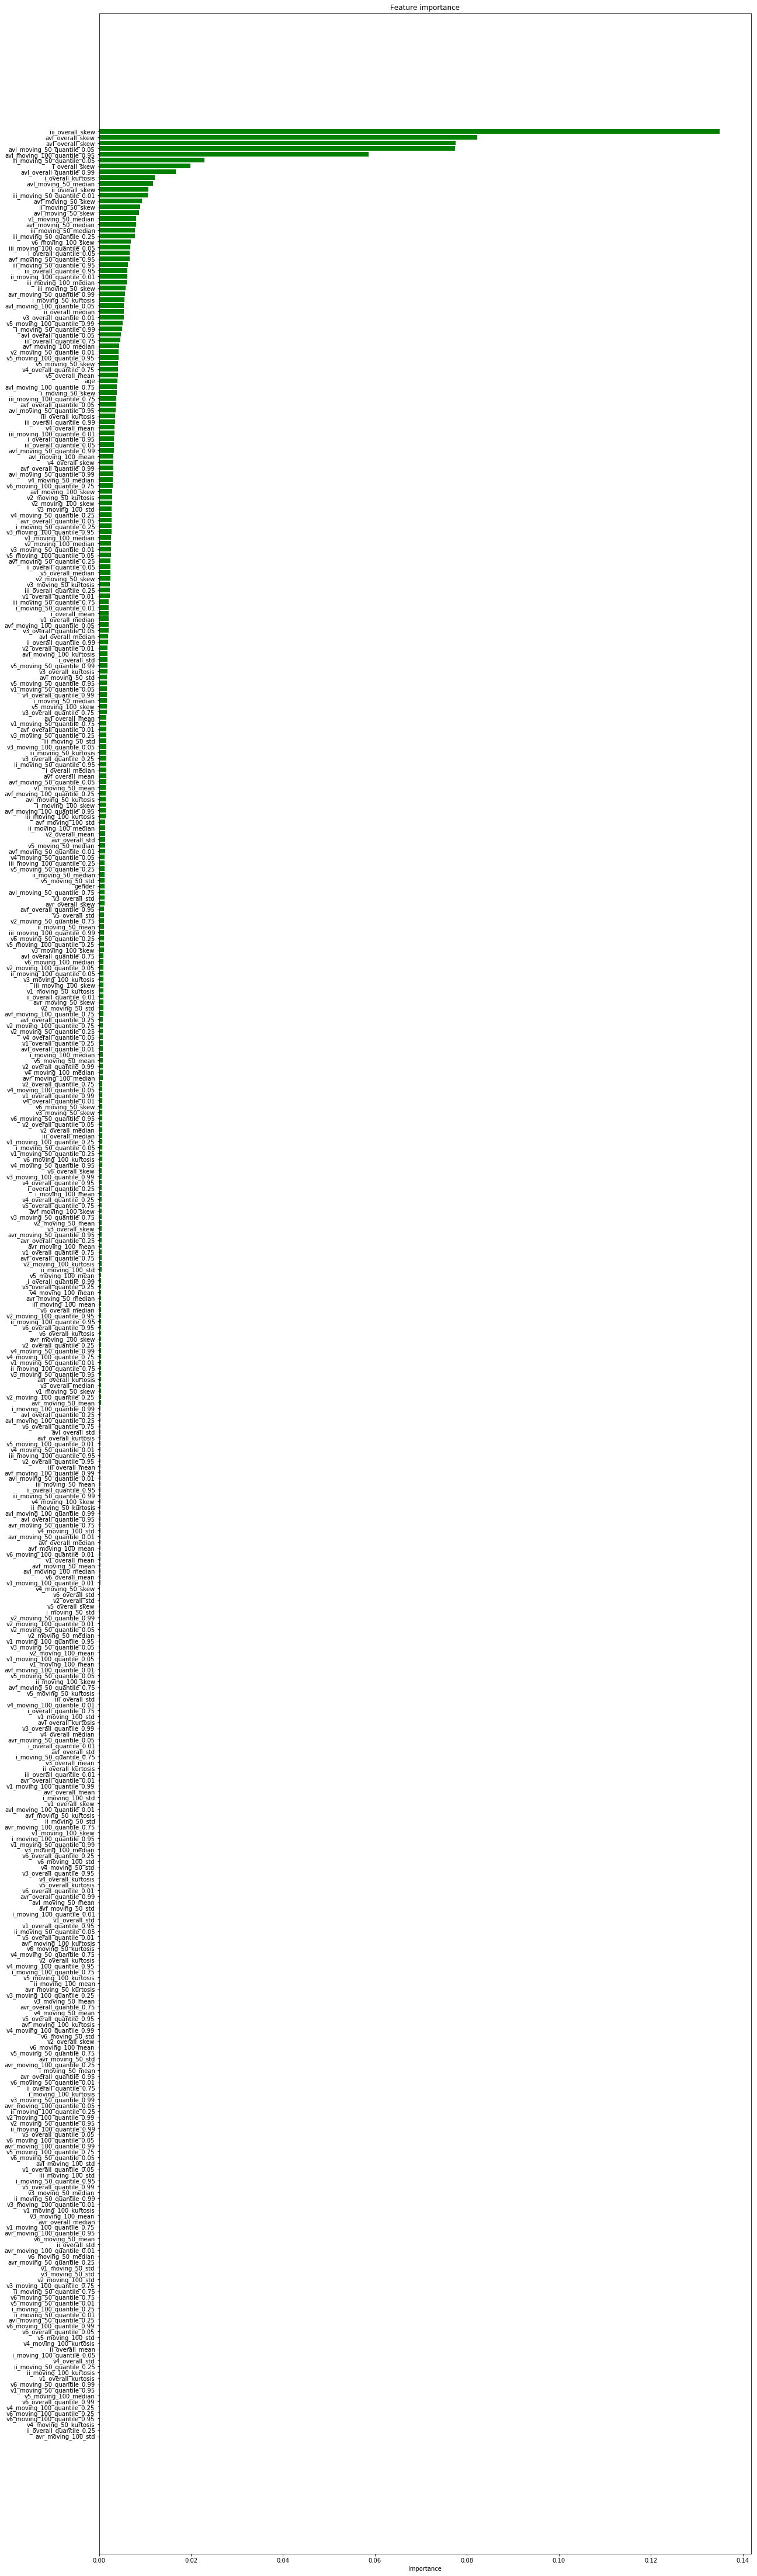

In [23]:
fig, ax = plt.subplots()

# Example data
order = np.argsort(-clf.feature_importances_)
people = train_data.columns[order]
y_pos = np.arange(len(people))
performance = clf.feature_importances_[order]

ax.barh(y_pos, performance, align='center',
        color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Importance')
ax.set_title('Feature importance')

plt.show()

In [24]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

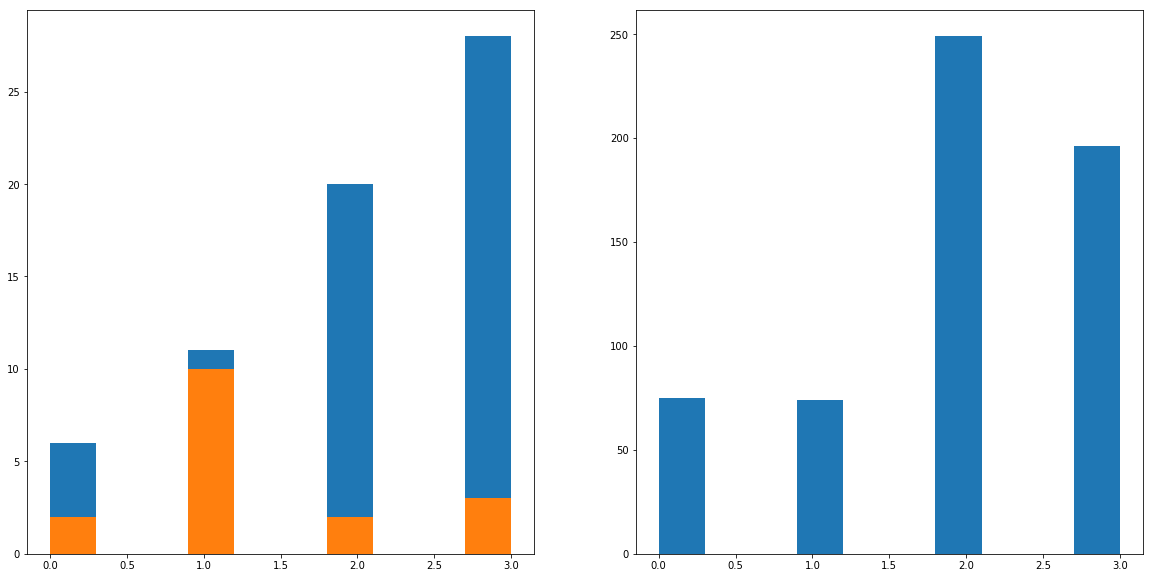

In [25]:
plt.subplot(121)
plt.hist(y_valid)
plt.hist(y_valid[y_valid != clf.predict(valid_data)])
plt.subplot(122)
plt.hist(y_train)
plt.hist(y_train[y_train != clf.predict(train_data)])

(array([ 81.,   0.,   0.,  85.,   0.,   0., 269.,   0.,   0., 224.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

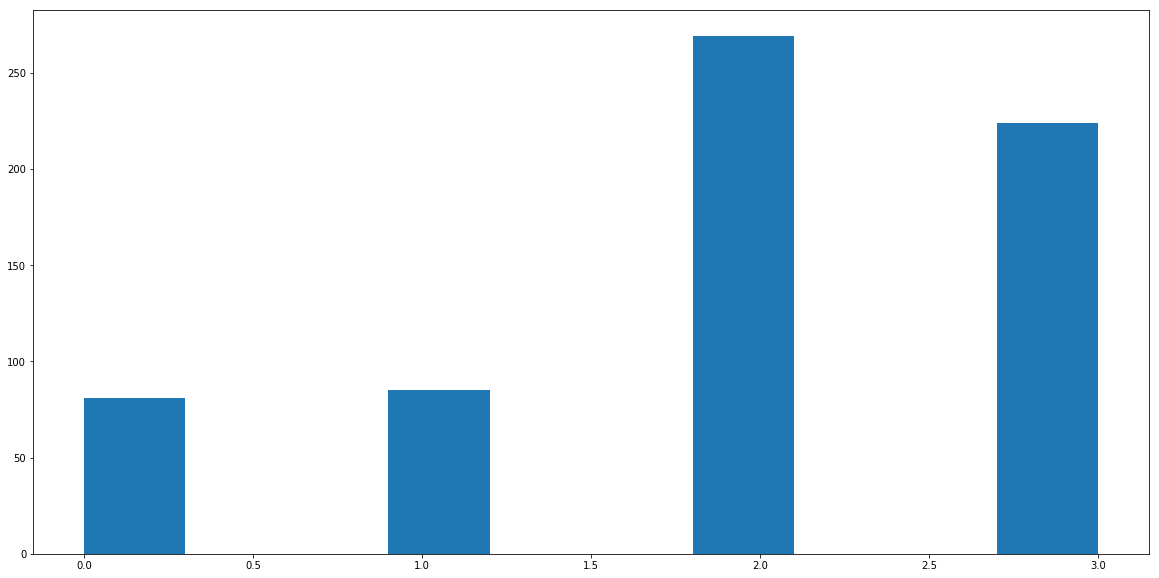

In [26]:
plt.hist(data['axis_id'])

In [27]:
from sklearn.metrics import confusion_matrix

In [28]:
confusion_matrix(y_valid, clf.predict(valid_data))

array([[ 4,  0,  2,  0],
       [ 0,  1,  6,  4],
       [ 0,  1, 18,  1],
       [ 0,  2,  1, 25]], dtype=int64)

In [29]:
import seaborn as sn

In [30]:
def plot_confusion_matrix(y_test, y_test_predict):
    sn.heatmap(confusion_matrix(y_test, y_test_predict), annot=True)


In [31]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

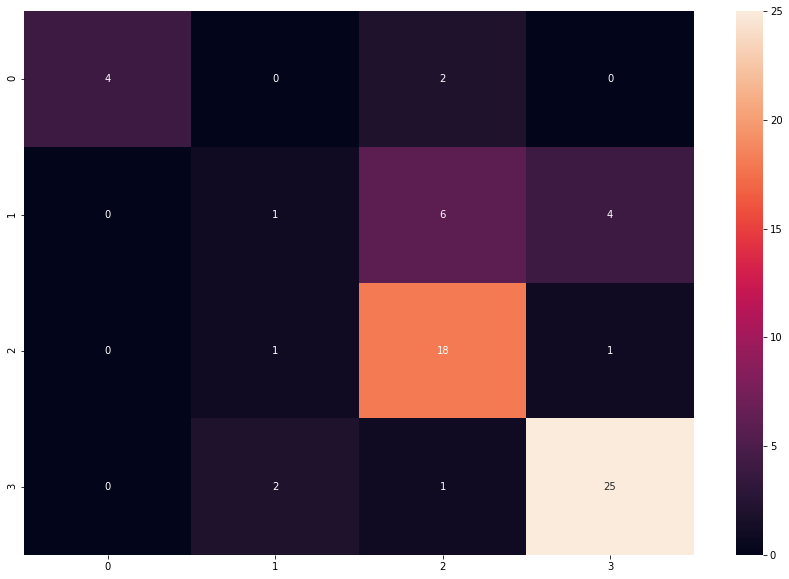

In [32]:
plot_confusion_matrix(y_valid, clf.predict(valid_data))

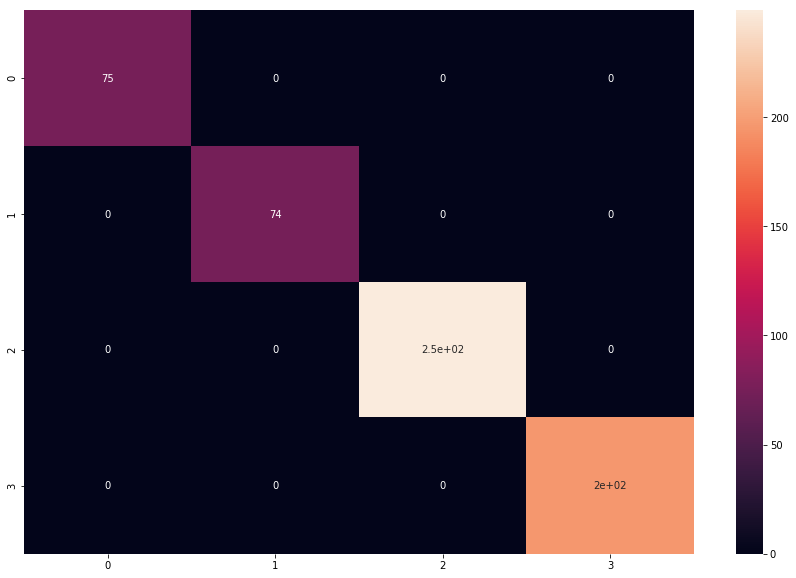

In [33]:
plot_confusion_matrix(y_train, clf.predict(train_data))

In [34]:
from sklearn.model_selection import cross_val_score

In [35]:
scores = cross_val_score(GradientBoostingClassifier(n_estimators=10000, learning_rate=0.1, max_depth=3, random_state=0),
                                          dataset, 
                                          data['axis_id'], cv = 4)

In [36]:
scores

array([0.73053892, 0.71341463, 0.71341463, 0.75      ])

In [37]:
from sklearn.model_selection import GridSearchCV

In [38]:
tuned_parameters = {
    "n_estimators":[100, 1000, 10000],
    "max_depth":[1,2,3,5,7],
    "learning_rate":[0.001, 0.0001, 0.00001]
}

In [39]:
clf_grid = GridSearchCV(GradientBoostingClassifier(), tuned_parameters, cv=5,
                       scoring="accuracy")
clf_grid.fit(train_data, y_train)

KeyboardInterrupt: 

In [ ]:
clf_grid.best_params_

In [ ]:
means = clf_grid.cv_results_['mean_test_score']
stds = clf_grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf_grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()